In [5]:
from SimPEG import Mesh, Maps, Utils
import numpy as np
from matplotlib.colors import LogNorm
from simpegEM1D import (
    GlobalEM1DProblemTD, GlobalEM1DSurveyTD, get_vertical_discretization_time, EM1DSurveyTD
)
from pymatsolver import PardisoSolver
from simpegEM1D import skytem_HM_2015

def get_xyz(
    dx=100, 
    dy=100, 
    nx=5, 
    ny=5, 
    x0=np.r_[0, 0, 0.]
):
    x = np.arange(nx)*dx + x0[0]
    y = np.arange(ny)*dy + x0[1]
    z = np.r_[0.]
    return Utils.ndgrid(x, y, z)
xyz_topo = get_xyz()
xyz = get_xyz(x0=np.r_[0, 0, 30.])

In [6]:
wave = skytem_HM_2015()
time = np.logspace(-5, -2, 21)

time_input_currents = wave.current_times[-7:]
input_currents = wave.currents[-7:]
n_sounding = xyz.shape[0]
hz = get_vertical_discretization_time(time, facter_tmax=0.5, factor_tmin=10.)
hx = np.ones(n_sounding)
mesh = Mesh.TensorMesh([hx, hz], x0='00')
inds = np.logical_and(mesh.gridCC[:,1]>25, mesh.gridCC[:,1]<75.) 
sigma = np.ones(mesh.nC) * 1./20.
sigma[inds] = 1./100.
sigma_em1d = sigma.reshape(mesh.vnC, order='F').flatten()

rx_locations = xyz.copy()
src_locations = xyz.copy()
topo = xyz_topo.copy()
mapping = Maps.ExpMap(mesh)

rx_type_global = np.array(["dBzdt"], dtype=str).repeat(n_sounding, axis=0)
field_type_global = np.array(['secondary'], dtype=str).repeat(n_sounding, axis=0)
wave_type_global = np.array(['general'], dtype=str).repeat(n_sounding, axis=0)
n_sounding = rx_locations.shape[0]
time_global = time.reshape([1,-1]).repeat(n_sounding, axis=0)
src_type_global = np.array(["CircularLoop"], dtype=str).repeat(n_sounding, axis=0)
a_global = np.array([13.], dtype=float).repeat(n_sounding, axis=0)
input_currents_global = input_currents.reshape([1,-1]).repeat(n_sounding, axis=0)
time_input_currents_global = time_input_currents.reshape([1,-1]).repeat(n_sounding, axis=0)
survey = GlobalEM1DSurveyTD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    topo = topo,
    time = time_global,
    src_type = src_type_global,
    rx_type = rx_type_global,    
    field_type = field_type_global,
    wave_type = wave_type_global,    
    a = a_global,
    input_currents=input_currents_global,
    time_input_currents=time_input_currents_global
)

prob = GlobalEM1DProblemTD(
    [], sigmaMap=mapping, hz=hz, parallel=True, ncpu=2,
    Solver=PardisoSolver
)
prob.pair(survey)

>> Set parameters


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [8]:
debug

> /Users/sgkang/Projects/simpegEM1D/simpegEM1D/GlobalEM1D.py(556)set_parameters()
    554 
    555         # List
--> 556         if not self.time_input_currents:
    557             self.time_input_currents = [
    558                 np.empty(1, dtype=float) for i in range(self.n_sounding)

ipdb> self.time_input_currents
array([[-0.004     , -0.00391   , -0.0038    ,  0.        ,  0.00019437,
         0.00019504,  0.00019637],
       [-0.004     , -0.00391   , -0.0038    ,  0.        ,  0.00019437,
         0.00019504,  0.00019637],
       [-0.004     , -0.00391   , -0.0038    ,  0.        ,  0.00019437,
         0.00019504,  0.00019637],
       [-0.004     , -0.00391   , -0.0038    ,  0.        ,  0.00019437,
         0.00019504,  0.00019637],
       [-0.004     , -0.00391   , -0.0038    ,  0.        ,  0.00019437,
         0.00019504,  0.00019637],
       [-0.004     , -0.00391   , -0.0038    ,  0.        ,  0.00019437,
         0.00019504,  0.00019637],
       [-0.004     , -0.003

# Seting up a 2D mesh and model

In [4]:
%%time
m = np.log(sigma_em1d)
dobs = survey.makeSyntheticData(m, std=0.05, force=True)

NameError: name 'sigma_em1d' is not defined

Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda2/envs/simpeg/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


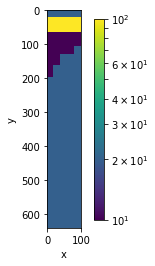

In [3]:
%pylab inline
cb = plt.colorbar(
    mesh.plotImage(1./sigma, grid=False, clim=(10., 100.),pcolorOpts={"norm":LogNorm()})[0],
    fraction=0.03, pad=0.04
)

plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)

In [4]:
DOBS = dobs.reshape((prob.n_sounding, 21))

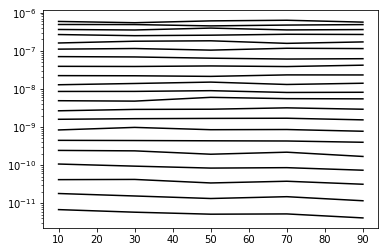

In [5]:
for i_time in range(21):
    plt.semilogy(mesh.vectorCCx, -DOBS[:,i_time], 'k')

In [6]:
from SimPEG import (
    Regularization, Directives, Inversion, InvProblem, Optimization, DataMisfit, Utils
)

In [7]:
mesh_reg = Mesh.TensorMesh([mesh.hy, mesh.hx])

In [8]:
%%time
std = 0.05
floor = 0.
np.random.seed(1)
uncert = std*abs(dobs)+floor
survey.dobs = dobs.copy()
m0 = np.ones(mesh.nC) * np.log(1./20.)
dmisfit = DataMisfit.l2_DataMisfit(survey)
regmap = Maps.IdentityMap(mesh)
# mapping is required ... for IRLS
reg = Regularization.Sparse(
    mesh_reg, mapping=regmap,
    alpha_s=1.,
    alpha_x = 2.,
    alpha_y = 2.,    
)
p = 0
qx, qz = 1., 1.
reg.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=5, minGNiter=1, fix_Jmatrix=True,
    betaSearch=False
)
opt = Optimization.InexactGaussNewton(maxIter = 20)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit()
# inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest,target])
inv = Inversion.BaseInversion(invProb, directiveList=[IRLS,betaest])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***


/Users/sgkang/Projects/simpeg/SimPEG/Directives.py:896: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.59e+02  2.66e+03  0.00e+00  2.66e+03    2.46e+03      0              
   1  7.94e+01  5.34e+02  1.45e+00  6.50e+02    3.22e+02      0              
   2  3.97e+01  3.01e+02  2.88e+00  4.16e+02    1.23e+02      0   Skip BFGS  
   3  1.98e+01  2.11e+02  4.54e+00  3.01e+02    7.10e+01      0   Skip BFGS  
   4  9.92e+00  1.32e+02  7.40e+00  2.05e+02    5.28e+01      0   Skip BFGS  
   5  4.96e+00  7.86e+01  1.11e+01  1.34e+02    3.51e+01      0   Skip BFGS  
   6  4.96e+00  5.27e+01  1.47e+01  1.26e+02    1.22e+01      0   Skip BFGS  
   7  4.96e+00  5.33e+01  1.44e+01  1.25e+02    8.53e+00      0              
   8  4.96e+00  5.29e+01  1.45e+01  1.25e+02    4.07e+00      0   Skip BFGS  
   9  4.96e+00  5.30e+01

In [9]:
sigma_est = Utils.mkvc((np.exp(mopt)).reshape((prob.n_sounding, prob.n_layer)))
sigma_est_l2 = Utils.mkvc((np.exp(invProb.l2model)).reshape((prob.n_sounding, prob.n_layer)))

In [10]:
import matplotlib
matplotlib.rcParams['font.size'] = 14

Text(0.5,1,'Laterally-contrained model: L0 L2')

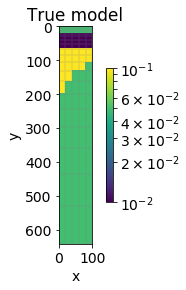

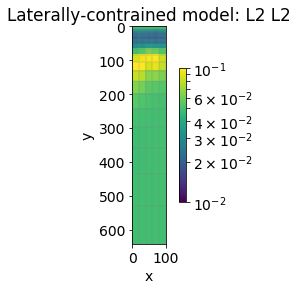

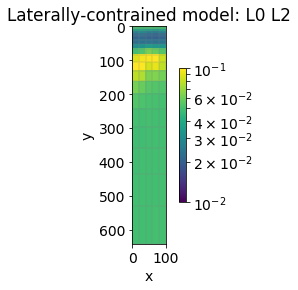

In [11]:
cb = plt.colorbar(
    mesh.plotImage(
        sigma, grid=True, clim=(1e-2, 1e-1),pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}
    )[0],
    fraction=0.02, pad=0.04
)

plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)

plt.title("True model")

cb = plt.colorbar(
    mesh.plotImage(
        sigma_est_l2, grid=True, clim=(1e-2, 1e-1),pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}
    )[0],
    fraction=0.02, pad=0.04
)
plt.title("Laterally-contrained model: L2 L2")
plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)


cb = plt.colorbar(
    mesh.plotImage(
        sigma_est, grid=True, clim=(1e-2, 1e-1), pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}
    )[0],
    fraction=0.02, pad=0.04
)
plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)
plt.title("Laterally-contrained model: L0 L2")

In [12]:
PRED = invProb.dpred.reshape((prob.n_sounding, 21))

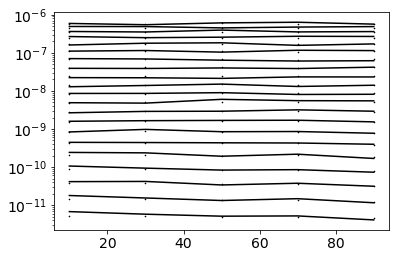

In [13]:
for i_time in range(21):
    plt.semilogy(mesh.vectorCCx, -DOBS[:,i_time], 'k')
    plt.semilogy(mesh.vectorCCx, -PRED[:,i_time], 'kx', ms=1)